## Asset Indices

Creates asset index from Oxford Policy Management (OPM) survey data using PCA and utilizing first component. Then, creates subgroups from the asset index for ammenities, appliances, transportation, and entertainment. Then creates additive indices for each index (main and sub-groups). Merges all back into the OPM data combined with cnn features (cnn_merge.csv) and exports the merged df (cnn_merge_w_assets). Creates correlation matrix figure between asset indices and pscores. Exports figure as "" in "opm_summary_figures" folder

## Setup

In [31]:
# imports
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sn
import matplotlib.pyplot as plt

# Set up sagemaker
import logging, os 
import boto3
from sagemaker import get_execution_role
from s3fs.core import S3FileSystem 
s3 = S3FileSystem()
role = get_execution_role()

# s3 bucket name
bucket = "worldbank-pakistan-data"
LOCAL_DIR = '/home/ec2-user/SageMaker/'

## Load Data

In [32]:
df = pd.read_csv(s3.open('{}/{}'.format(bucket, os.path.join('OPM', 'FinalData', 'Merged Datasets', 'cnn_merge_pca.csv'))))
df['pscores_poor'] = df.pscores <= 16.17
df['pscores_poor_med'] = df.pscores <= df.pscores.median()

## Functions

In [33]:
def index(df):
    pca = PCA(n_components=1)
    pca.fit(df)
    df_pca = pca.transform(df) ###merge into cnn_merge
    index = pd.DataFrame(pca.components_, columns=list(df.columns))
    for i in range(len(index)):
        for j in range(len(df.columns)):
            if (index.loc[i][j]<.01):
                index.loc[i][j]=0
    index=index.replace(0, np.nan) 
    index=index.T
    index=index.dropna(axis=0)
    index.columns=['PCA_component']
    df_index=index.T.columns
    df_index=df_index.tolist()
    df_index #final asset index (list of what assets we want to include)
    return(df_pca, df_index)

def additive(df):
    additive=df.iloc[:,:].sum(axis=1) #final additive index of ammenities to be added to dataframe
    return(additive)

## Create Asset Indices & Additive Asset Indices

In [34]:
#main asset index & additive
asset_df=df.filter(regex="asset_") #pulls out all columns with name "asset"
asset_df=asset_df.filter(regex="^(?!.*index_).*$") #ditches older asset indices, creating a dataframe of only the assets
asset_df['uid']=df['uid']
asset_df=asset_df.set_index('uid')
asset_df=asset_df.dropna()

asset_index=index(asset_df)
asset_pca=asset_index[0]
additive_of_main=additive(asset_df)

#ammenities index & additive
columns=['asset_fan_ceiling_table_pedestal_exhaust', 'asset_washing_machinedryer', 'asset_air_cooler', 'asset_sewingknitting_machine', 
'asset_motorcycle',  'asset_bicycle', 'asset_tv', 'asset_vcr_vcp_receiver_decoder', 'asset_dryer', 'asset_heater', 'asset_air_conditioner', 'asset_personal_computer',
'asset_radio_cassette_player', 'asset_camera_movie_', 'asset_microwave_oven', 'asset_compact_disk_player', 'asset_car', 'asset_scooter',
'asset_tractor', 'asset_vacuum_cleaner', 'asset_camera_still']
ammenit_df=df[columns]
ammenit_df['uid']=df['uid']
ammenit_df=ammenit_df.set_index('uid')
ammenit_df=ammenit_df.dropna()

ammenit_index=index(ammenit_df)
ammenit_pca=ammenit_index[0]
additive_of_ammenit=additive(ammenit_df)

#appliances index & additive

columns=['asset_cooking_stove', 'asset_cooking_range', 'asset_refrigerator', 'asset_freezer', 'asset_geyser_gas_electric']
applian_df=df[columns]
applian_df['uid']=df['uid']
applian_df=applian_df.set_index('uid')
applian_df=applian_df.dropna()

applian_index=index(applian_df)
applian_pca=applian_index[0]
additive_of_applian=additive(applian_df)

# entertainment

columns=['asset_personal_computer', 'asset_tv', 'asset_vcr_vcp_receiver_decoder', 'asset_radio_cassette_player', 'asset_camera_movie_',
 'asset_compact_disk_player', 'asset_camera_still']
entert_df=df[columns]
entert_df['uid']=df['uid']
entert_df=entert_df.set_index('uid')
entert_df=entert_df.dropna()

entert_index=index(entert_df)
entert_pca=entert_index[0]
additive_of_entert=additive(entert_df)

# transportation

columns=['asset_motorcycle', 'asset_bicycle', 'asset_car', 'asset_scooter', 'asset_tractor']
transp_df=df[columns]
transp_df['uid']=df['uid']
transp_df=transp_df.set_index('uid')
transp_df=transp_df.dropna()

transp_index=index(transp_df)
transp_pca=transp_index[0]
additive_of_transp=additive(transp_df)

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/ipykernel/__main__.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

## Add Asset & Additive Indices

In [35]:
df = df.drop(369) #drops the nan rows from the asset columns
df['asset_pca']=asset_pca
additive_of_main=pd.DataFrame(additive_of_main,columns=['additive_of_main'])
df = df.merge(additive_of_main, on='uid')
df['ammenit_pca']=ammenit_pca
additive_of_ammenit=pd.DataFrame(additive_of_ammenit,columns=['additive_of_ammenit'])
df = df.merge(additive_of_ammenit, on='uid')
df['applian_pca']=applian_pca
additive_of_applian=pd.DataFrame(additive_of_applian,columns=['additive_of_applian'])
df = df.merge(additive_of_applian, on='uid')
df['transp_pca']=transp_pca
additive_of_transp=pd.DataFrame(additive_of_transp,columns=['additive_of_transp'])
df = df.merge(additive_of_transp, on='uid')
df['entert_pca']=entert_pca
additive_of_entert=pd.DataFrame(additive_of_entert,columns=['additive_of_entert'])
df = df.merge(additive_of_entert, on='uid')
display(df)
df.to_csv(os.path.join(LOCAL_DIR,'cnn_merge_w_assets.csv'), index=False)
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('OPM', 'FinalData','Merged Datasets','cnn_merge_w_assets.csv')).upload_file(os.path.join(LOCAL_DIR, 'cnn_merge_w_assets.csv'))

,cnn_pc_0_Nbands3,cnn_pc_1_Nbands3,cnn_pc_2_Nbands3,cnn_pc_3_Nbands3,cnn_pc_4_Nbands3,cnn_pc_5_Nbands3,cnn_pc_6_Nbands3,cnn_pc_7_Nbands3,cnn_pc_8_Nbands3,cnn_pc_9_Nbands3,...,asset_pca,additive_of_main,ammenit_pca,additive_of_ammenit,applian_pca,additive_of_applian,transp_pca,additive_of_transp,entert_pca,additive_of_entert
0,39.657277,316.585818,123.730639,-99.734413,74.571333,-280.209761,-37.870327,-147.286224,110.369955,-76.421150,...,0.133066,3.0,-0.098347,2.0,0.517764,1.0,-0.267899,0.0,0.563201,1.0
1,-727.501455,22.666208,-32.150750,55.803616,-80.666177,121.495729,-48.543442,-129.536411,-51.163886,1.646401,...,-0.049947,3.0,0.046258,3.0,-0.314641,0.0,-0.200183,1.0,-0.433604,0.0
2,-582.583372,254.735452,-21.474623,-114.379673,-70.889502,120.352252,-112.789128,-249.261587,-56.150562,45.430507,...,-0.238062,2.0,-0.098347,2.0,-0.314641,0.0,-0.267899,0.0,0.563201,1.0
3,-698.695464,64.260335,-23.856801,51.578066,-83.343577,126.602706,-62.152917,-138.074619,-36.396963,-8.506154,...,-0.749674,1.0,-0.693127,1.0,-0.314641,0.0,-0.267899,0.0,-0.433604,0.0
4,-85.636413,243.275270,114.789374,-41.459777,117.812657,-240.293008,27.189732,-116.371592,114.466050,-94.985057,...,0.968740,6.0,0.454189,4.0,1.071359,2.0,-0.267899,0.0,0.636058,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,204.673850,400.873688,-70.966509,-293.626079,-504.540720,-240.423755,-67.065163,211.999657,38.018591,-111.774650,...,-0.378546,2.0,-0.693127,1.0,0.517764,1.0,-0.267899,0.0,-0.433604,0.0
3367,806.914154,98.512449,84.144506,8.965299,-472.037543,-91.340628,158.980350,-32.642145,182.642022,-262.018087,...,-0.337235,3.0,-0.656079,2.0,0.517764,1.0,-0.267899,0.0,-0.433604,0.0
3368,324.711025,474.021900,142.299132,585.625145,293.266516,-114.732508,342.246139,214.876727,89.188714,61.679333,...,0.133066,3.0,-0.098347,2.0,0.517764,1.0,-0.267899,0.0,0.563201,1.0
3369,1420.607909,74.648030,368.814334,631.374504,-369.987671,-84.238138,-71.564711,16.603831,24.374361,49.758432,...,1.595901,8.0,1.198979,6.0,1.071359,2.0,-0.200183,1.0,0.563201,1.0


## Creating Correlation Coefficient Matrix Figure

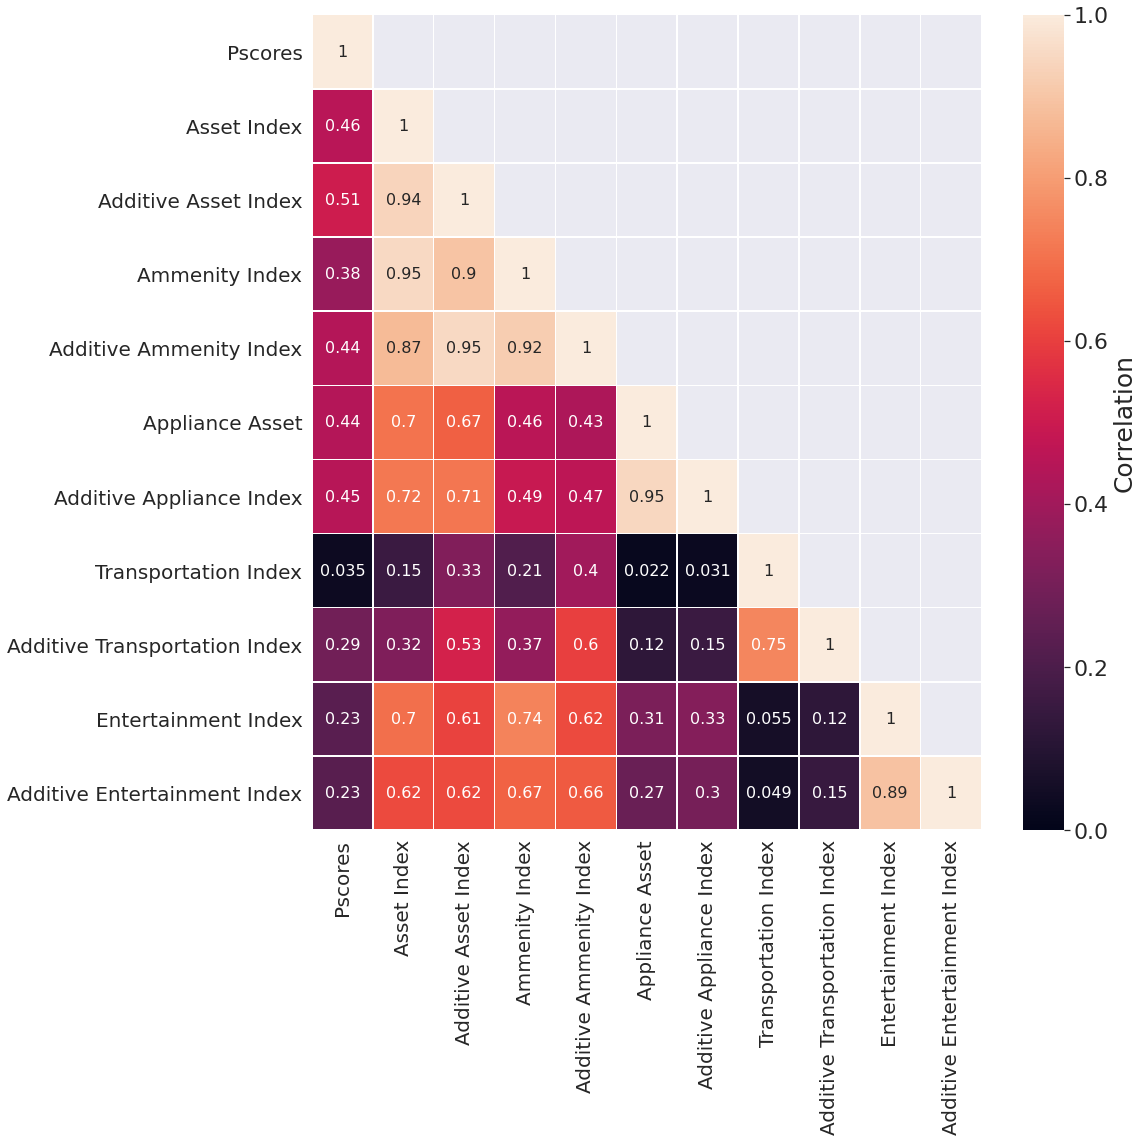

<Figure size 432x288 with 0 Axes>

In [37]:
columns=['pscores']
list_of_index=['asset_pca',
     'additive_of_main',
     'ammenit_pca',
     'additive_of_ammenit',
     'applian_pca',
     'additive_of_applian',
     'transp_pca',
     'additive_of_transp',
     'entert_pca',
     'additive_of_entert']
columns.extend(list_of_index)

df=df[columns]
corr=df.corr()
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))


x=['Pscores','Asset Index', 'Additive Asset Index', 'Ammenity Index', 'Additive Ammenity Index', 'Appliance Asset', 'Additive Appliance Index',
  'Transportation Index', 'Additive Transportation Index', 'Entertainment Index', 'Additive Entertainment Index']
fig, ax = plt.subplots(figsize=(15,15))  
sn.set(font_scale=2)
heat = sn.heatmap(df_lt, vmin=0, vmax=1, annot=True, linewidths=.5, cbar_kws={'label': 'Correlation'}, annot_kws={"size":16})
heat.set_xticklabels(x,fontsize = 20)
heat.set_yticklabels(x,fontsize = 20)
heat.figure.axes[-1].yaxis.label.set_size(25)
plt.show()

#can't get graph to save appropriately:

#plt.savefig(os.path.join(LOCAL_DIR,'asset_corr_matrix.png'))
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join('Poverty Estimation Results', 'continuous', 'asset_corr_matrix.png')).upload_file(os.path.join(LOCAL_DIR,'asset_corr_matrix.png'))